#                   TIME SERIES PROJECT

## Problem Statement:

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users within next 18 months. In order to help Unicorn Ventures in their decision, we need to forecast the traffic on JetRail for the next 7 months. We are provided with traffic data of JetRail since inception in the test file.

### Now that we have the understanding of the problem statement, let’s look at the steps that we will follow to solve the problem at hand.

#### **Table of Contents**

**a) Understanding Data:**
1. Hypothesis Generation
2. Getting the system ready and loading the data
3. Dataset Structure and Content
4. Feature Extraction
5. Exploratory Analysis

**b) Forecasting using Multiple Modeling Techniques:**
1. Splitting the data into training and validation part
2. Modeling techniques
3. Holt’s Linear Trend Model on daily time series
4. Holt Winter’s Model on daily time series
5. Introduction to ARIMA model
6. Parameter tuning for ARIMA model
7. SARIMAX model on daily time series

### **(a) Understanding the data**

### 1. HYPOTHESIS GENERATION

We will start with the first step, i.e. **Hypothesis Generation**. Hypothesis Generation is the process of listing out all the possible factors that can affect the outcome.

Hypothesis generation is done before having a look at the data in order to avoid any bias that may result after the observation.
It helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

1. There will be an increase in the traffic as the years pass by.
   - Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also,                        generally companies expand their businesses over time leading to more customers travelling through JetRail.
2. The traffic will be high from May to October.
   - Explanation - Tourist visits generally increases during this time perion.
3. Traffic on weekdays will be more as compared to weekends/holidays.
   - Explanation - People will go to office on weekdays and hence the traffic will be more
4. Traffic during the peak hours will be high.
   - Explanation - People will travel to work, college.
   
We will try to validate each of these hypothesis based on the dataset. 

### 2. LOADING THE DATA


In [1]:
import pandas as pd
import numpy as np                #for mathematical calculations
import matplotlib.pyplot as plt   #for plotting the graphs
from datetime import datetime     #for datetime functions
from pandas import Series
%matplotlib inline
import warnings                   #to ignore warnings
warnings.filterwarnings("ignore")

#### Reading the test and train data:

In [2]:
train=pd.read_csv("Train_SU63ISt.csv")  #reading the csv files into dataframes
test=pd.read_csv("Test_0qrQsBZ.csv")

Let’s make a copy of train and test data so that even if we do changes in these dataset we do not lose the original dataset.

In [3]:
test_original=test.copy()
train_original=train.copy()

### 3. DATASET STRUCTURE AND CONTENT

In [4]:
train.columns

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [5]:
test.columns

Index(['ID', 'Datetime'], dtype='object')

We have ID, Datetime and corresponding count of passengers in the train file. For test file we have ID and Datetime only so we have to predict the Count for test file.

Let’s understand each feature first:

- **ID** is the unique number given to each observation point.
- **Datetime** is the time of each observation.
- **Count** is the passenger count corresponding to each Datetime.

Let’s look at the data types of each feature.

In [6]:
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [7]:
test.dtypes

ID           int64
Datetime    object
dtype: object

- ID and Count are in integer format while the Datetime is in object format for the train file.
- Id is in integer and Datetime is in object format for test file.

Now we will see the shape of the dataset.

In [8]:
train.shape,test.shape

((18288, 3), (5112, 2))

We have 18288 different records for the Count of passengers in train set and 5112 in test set.

### 4. FEATURE EXTRACTION

In [9]:
train.head(5)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


Here we see that the 'Datetime' column has combined value of date along with the time. So we will extract the time and date from the Datetime. We have seen earlier that the data type of 'Datetime' is object. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [10]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')   #changing the format of the 'Datetime' column
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [11]:
train.head(5)

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [12]:
for i in (train, test, test_original, train_original):    #extracting year,month,day and hour from 'Datetime' column.
    i['Year']=i.Datetime.dt.year 
    i['Month']=i.Datetime.dt.month 
    i['Day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

In [13]:
train.head()  #checking the modified dataframe i.e with added columns for year,month,day and hour.

,ID,Datetime,Count,Year,Month,Day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


Similarly all the datasets are modified with added columns "Year", "Month", "Day" and "Hour".

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.

- We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.(Using function dayofweek() in datetime module)
- Values of 5 and 6 represents that the days are weekend.

( 'dayofweek' function return the day of the week as an integer, where Monday is 0 and Sunday is 6.)


In [14]:
train['Day_of_week']=train['Datetime'].dt.dayofweek
temp1=train['Datetime']

In [15]:
train.head()             #Day_of_week column shows the corresponding day starting from 0(Monday) to 6(Sunday).

,ID,Datetime,Count,Year,Month,Day,Hour,Day_of_week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5


Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.
Defining a function for this work.

In [15]:
def check_weekend(row):                                                  #return 1 if weekend(5 and 6 i.e. Sat and Sun),else 0
    if row.dayofweek ==5 or row.dayofweek==6:
        return 1
    else:
        return 0

Now applying this function on the train dataset.

In [16]:
train['Weekend']=train['Datetime'].apply(check_weekend)


In [17]:
train.head()

,ID,Datetime,Count,Year,Month,Day,Hour,Day_of_week,Weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


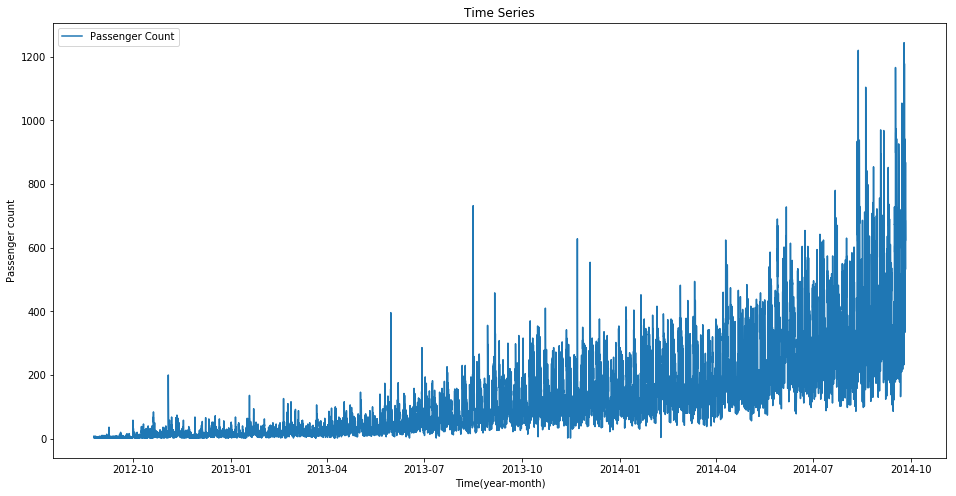

In [18]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis.
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

We will work on the train file for all the analysis and will use the test file for forecasting.

### 5. EXPLORATORY ANALYSIS

Let us try to verify our hypothesis using the actual data.

- **Our first hypothesis was "traffic will increase as the years pass by**". So let’s look at yearly passenger count.

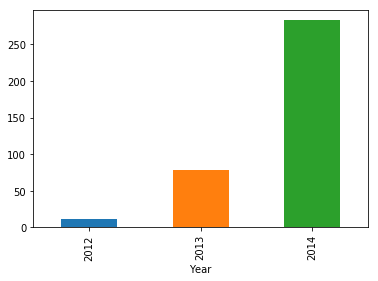

In [19]:
train.groupby('Year')['Count'].mean().plot.bar()

We see an exponential growth in the traffic with respect to year which validates our hypothesis.

- **Our second hypothesis was about increase in traffic from May to October.** So, let’s see the relation between count and month.

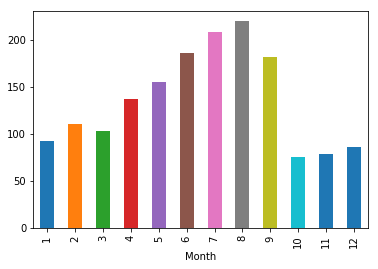

In [20]:
train.groupby('Month')['Count'].mean().plot.bar()

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

In [21]:
temp=train.groupby(['Year','Month'])['Count'].mean()   #ordering the train dataset according to year and month.


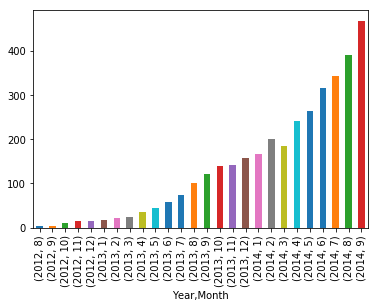

In [22]:
t1=temp.plot.bar()

We can also see this increasing trend by visualizing the line graph as shown below.

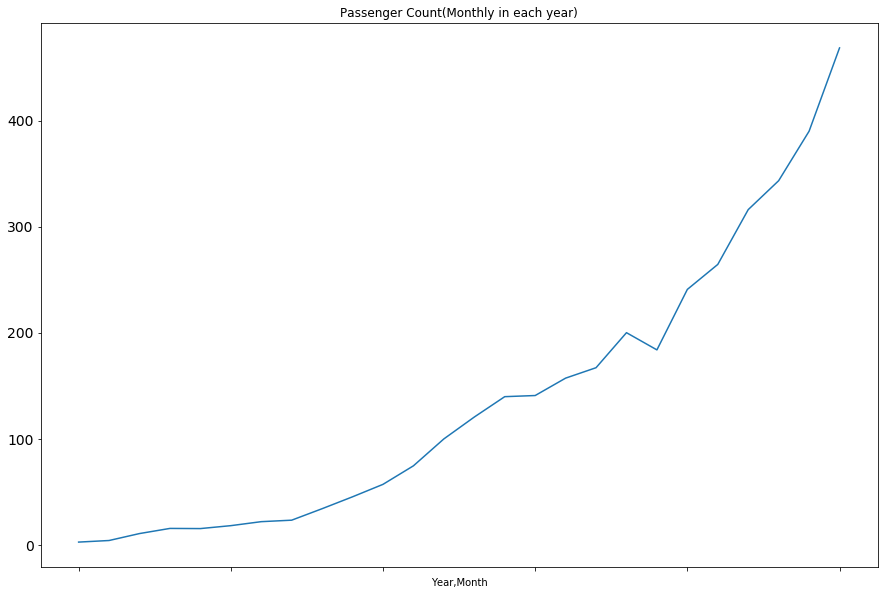

In [23]:
t2=temp.plot(figsize=(15,10),title='Passenger Count(Monthly in each year)',fontsize=14)

In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

- Let’s look at the daily mean of passenger count.

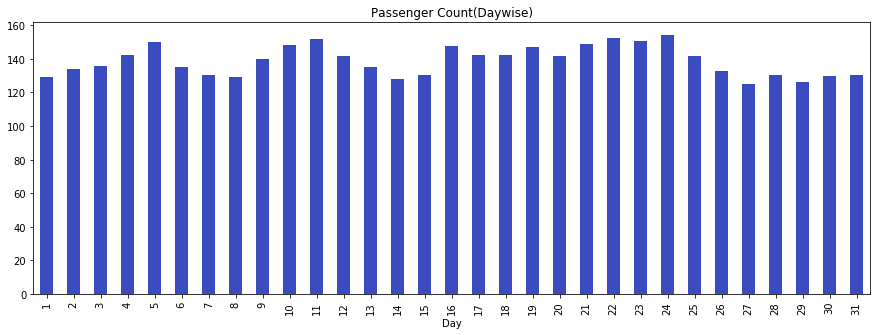

In [24]:
train.groupby('Day')['Count'].mean().plot.bar(figsize=(15,5),title='Passenger Count(Daywise)',cmap='coolwarm')

We are not getting much insights from day wise count of the passengers.

- We also made a hypothesis that the traffic will be more during peak hours. So let’s see the mean of hourly passenger count.

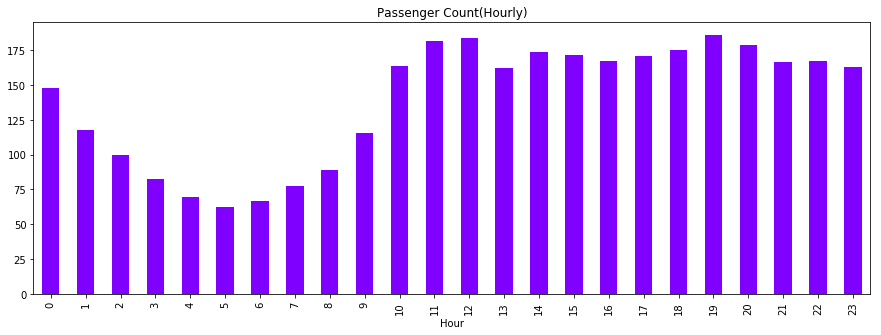

In [25]:
train.groupby('Hour')['Count'].mean().plot.bar(figsize=(15,5),title='Passenger Count(Hourly)',cmap='rainbow')

- It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
- After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.




**Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.**

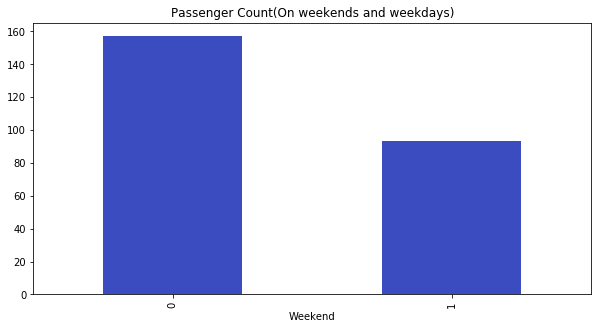

In [26]:
train.groupby('Weekend')['Count'].mean().plot.bar(figsize=(10,5),title='Passenger Count(On weekends and weekdays)',cmap='coolwarm')

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

Now we will try to look at the day wise passenger count.

**Note** - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

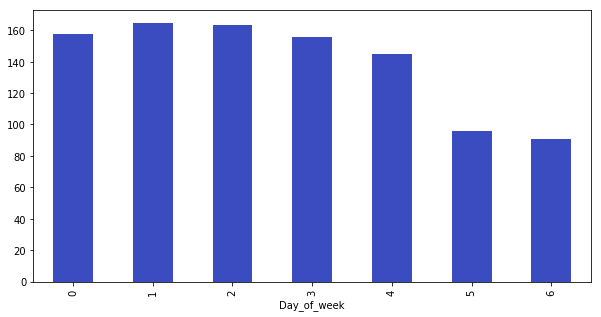

In [27]:
train.groupby('Day_of_week')['Count'].mean().plot.bar(figsize=(10,5),cmap='coolwarm')

From the above bar plot, we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week. 
Now we will look at basic modeling techniques. Before that we will drop the ID variable as it has nothing to do with the passenger count.

In [28]:
train=train.drop('ID',axis=1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.


In [29]:
train.Timestamp=pd.to_datetime(train.Datetime,format='%d-%m-%y %H:%M')
train.index=train.Timestamp   #to store axis labels as the time i.e x-axis will have 'time' as the label. 

#Resample method: Convenience method for frequency conversion and resampling of time series. 
#Object must have a datetime-like index .

#Hourly time series
hourly=train.resample('H').mean()

#daily time series
daily=train.resample('D').mean()

#weekly time series
weekly=train.resample('W').mean()

#monthly time series
monthly=train.resample('M').mean()


Let’s look at the hourly, daily, weekly and monthly time series.

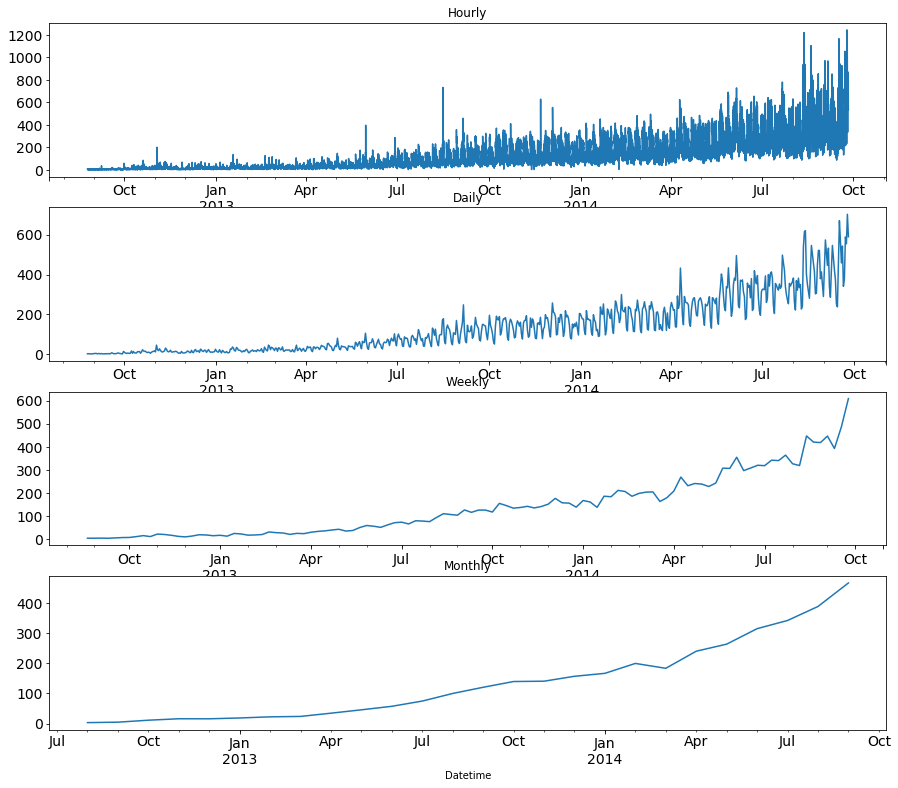

In [30]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,18), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,13), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,13), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,13), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [31]:
#FOR 'TEST' DATASET:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

#FOR 'TRAIN' DATASET
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

### **(b) Forecasting using Multiple Model Techniques:**

### **1. SPLITTING THE DATA INTO TRAINING AND VALIDATION SETS:**

As we have validated all our hypothesis, let’s go ahead and build models for Time Series Forecasting. But before we do that, we will need a dataset(validation) to check the performance and generalisation ability of our model. Below are some of the properties of the dataset required for the purpose.

The dataset should have the true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.

The model should not be trained on the validation dataset. Hence, we cannot train the model on the train dataset and validate on it as well.

So, for the above two reasons, we generally divide the train dataset into two parts. One part is used to train the model and the other part is used as the validation dataset. Now there are multiple ways to divide the train dataset such as Random Division etc.

For this course, We will be using a time based split explained below.

Now we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [32]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-25':'2014-09-24']   
#.ix[] supports mixed integer and label based access.
#It is primarily label based, but will fall back to integer positional access unless the corresponding axis is of integer type.

- We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

- Lets understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

Now we will look at how the train and validation part has been divided.

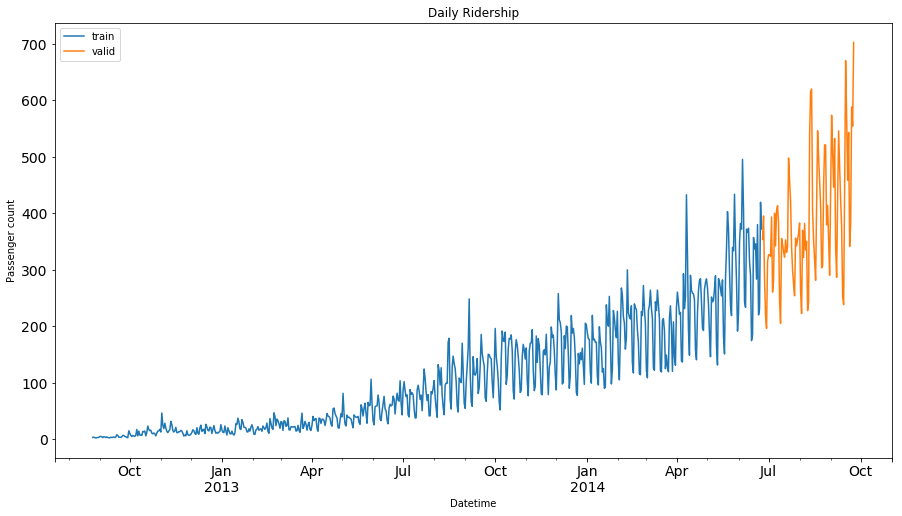

In [33]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') #'Count' is the column name here.
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

Here the blue part represents the train data and the orange part represents the validation data.

We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.

### **2. MODELING TECHNIQUES:** 

We will look at various models now to forecast the time series . Methods which we will be discussing for the forecasting are:

- i) Naive Approach 
- ii) Moving Average
- iii) Simple Exponential Smoothing
- iv) Holt’s Linear Trend Model

We will discuss each of these methods in detail now.


### **i) Naive Approach:**
In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. Lets understand it with an example and an image:

Suppose we have passenger count for 5 days as shown below:

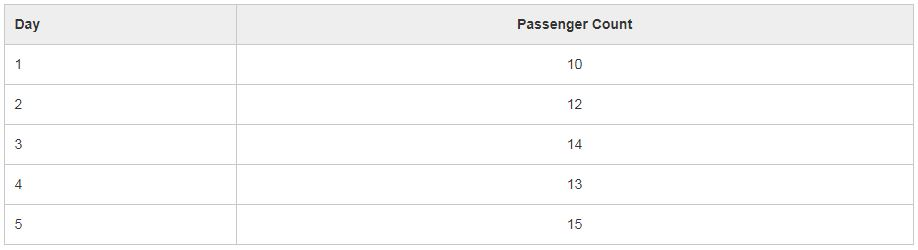

And we have to predict the passenger count for next 2 days. Naive approach will assign the 5th day’s passenger count to the 6th and 7th day, i.e., 15 will be assigned to the 6th and 7th day.

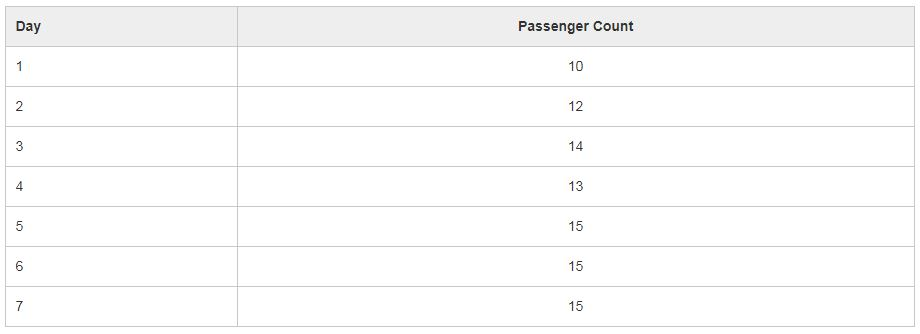

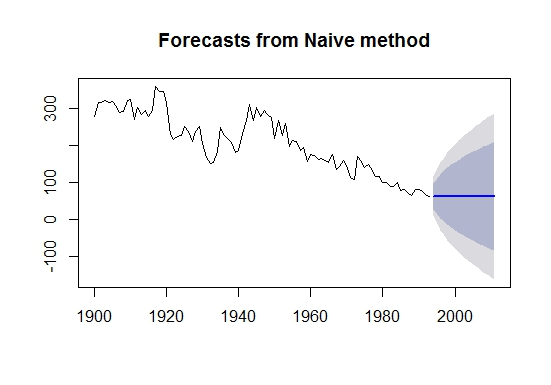

The blue line is the prediction here. All the predictions are equal to the last observed point.

Let’s make predictions using naive approach for the validation set.

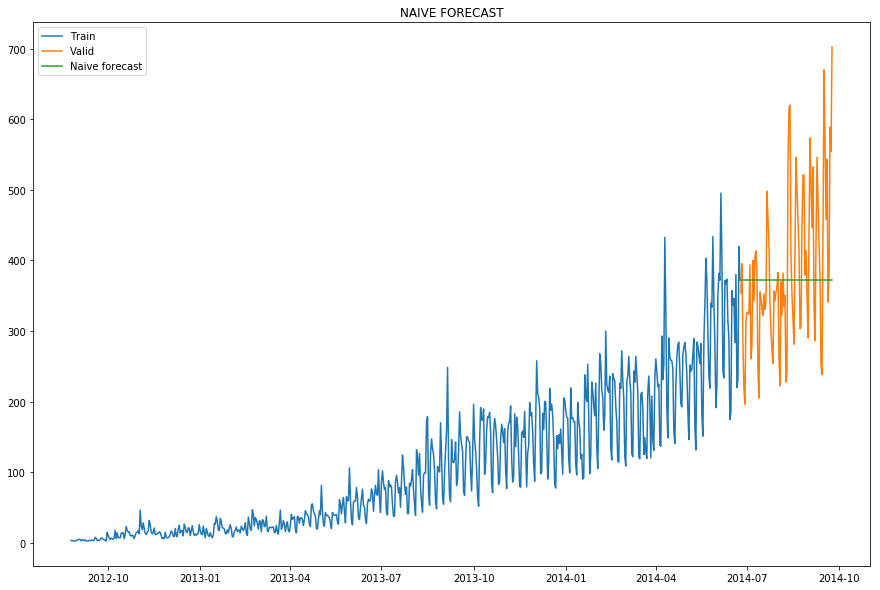

In [34]:
Count_values=np.asarray(Train.Count)  #converts 'Count' column of 'Train' dataframe into an array
y_hat=valid.copy()               #create a copy of 'valid' dataframe because now we have to predict values for 'valid' dataframe.
y_hat['naive']=Count_values[len(Count_values)-1]   #to assign value of last day and take it as prediction for the next values following
plt.figure(figsize=(15,10))
plt.plot(Train.index,Train['Count'],label='Train')
plt.plot(valid.index,valid['Count'],label='Valid')
plt.plot(y_hat.index,y_hat['naive'],label='Naive forecast')
plt.legend(loc='best')
plt.title('NAIVE FORECAST')
plt.show()

We can calculate how accurate our predictions are using rmse(Root Mean Square Error).
- rmse is the standard deviation of the residuals.
- Residuals are a measure of how far from the regression line data points are.
- The formula for rmse is:

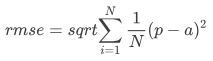

We will now calculate RMSE to check the accuracy of our model on validation data set.

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_naive=sqrt(mean_squared_error(valid.Count,y_hat.naive))  #root mean square value for naive approach.
rmse_naive

110.08522513706487

We can infer that this method is not suitable for datasets with high variability. We can reduce the rmse value by adopting different techniques.

### **ii) Moving Average:** 
In this technique we will take the average of the passenger counts for last few time periods only.

Let’s take an example to understand it:

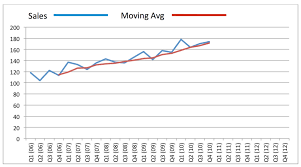

Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values.

Lets try the rolling mean for last 10, 20, 50 days and visualize the results.



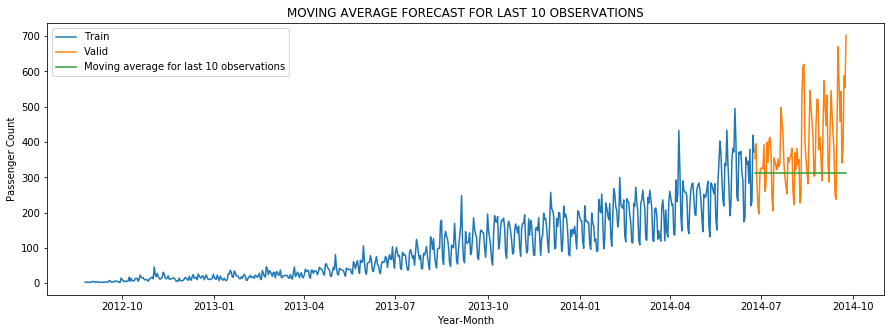

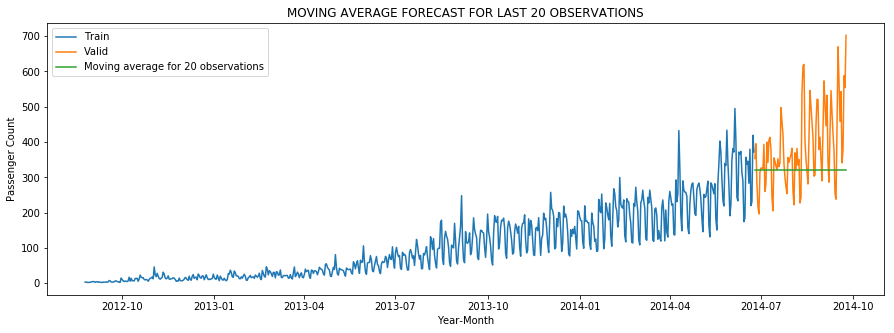

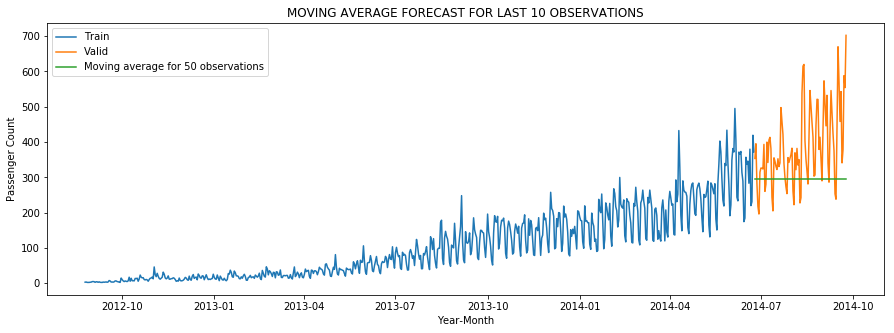

In [36]:
#FOR LAST 10 OBSERVATIONS:
y_hat_avg=valid.copy()
y_hat_avg['Moving_average']=Train['Count'].rolling(10).mean().iloc[-1] #average of last 10 observations
plt.figure(figsize=(15,5))
plt.plot(Train.Count,label='Train')
plt.plot(valid.Count,label='Valid')
plt.plot(y_hat_avg.Moving_average,label='Moving average for last 10 observations')
plt.title('MOVING AVERAGE FORECAST FOR LAST 10 OBSERVATIONS')
plt.xlabel('Year-Month')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

#FOR LAST 20 OBSERVATIONS:
y_hat_avg=valid.copy()
y_hat_avg['Moving_average']=Train['Count'].rolling(20).mean().iloc[-1] #average of last 10 observations
plt.figure(figsize=(15,5))
plt.plot(Train.Count,label='Train')
plt.plot(valid.Count,label='Valid')
plt.plot(y_hat_avg.Moving_average,label='Moving average for 20 observations')
plt.title('MOVING AVERAGE FORECAST FOR LAST 20 OBSERVATIONS')
plt.xlabel('Year-Month')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

#FOR LAST 50 OBSERVATIONS:
y_hat_avg=valid.copy()
y_hat_avg['Moving_average']=Train['Count'].rolling(50).mean().iloc[-1] #average of last 10 observations
plt.figure(figsize=(15,5))
plt.plot(Train.Count,label='Train')
plt.plot(valid.Count,label='Valid')
plt.plot(y_hat_avg.Moving_average,label='Moving average for 50 observations')
plt.title('MOVING AVERAGE FORECAST FOR LAST 10 OBSERVATIONS')
plt.xlabel('Year-Month')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

We took the average of last 10, 20 and 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part. We can see that the predictions are getting weaker as we increase the number of observations.

In [37]:
#Again checking the root mean square for moving average method:
rmse_mov_avg=sqrt(mean_squared_error(valid.Count,y_hat_avg.Moving_average))
rmse_mov_avg

141.71753106397807

### **iii) Simple Exponential Smoothing:** 
In this technique, we assign larger weights to more recent observations than to observations from the distant past.The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

NOTE - If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.

In [38]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing,Holt    #for statistical modeling

#statsmodels.tsa contains model classes and functions that are useful for time series analysis.

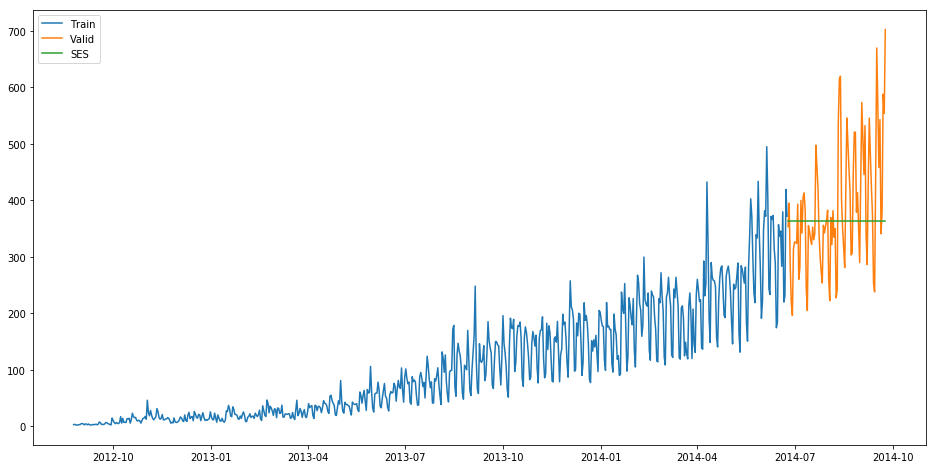

In [39]:
y_hat_ses = valid.copy()    #dataframe for simple exponential smoothing
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_ses['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_ses['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [40]:
#Calculating rmse value for Simple Exponential Smoothing method:
rmse_ses=sqrt(mean_squared_error(valid.Count,y_hat_ses.SES))
rmse_ses

111.58834236851837

We can infer that the fit of the model has improved as the rmse value has reduced.

### **iv) Holt’s Linear Trend Model:**
It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.
First of all let us visualize the trend, seasonality and error in the series.

We can decompose the time series in four parts.

- Observed, which is the original time series.
- Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
- Seasonal, which tells us about the seasonality in the time series.
- Residual, which is obtained by removing any trend or seasonality in the time series.

Lets visualize all these parts.

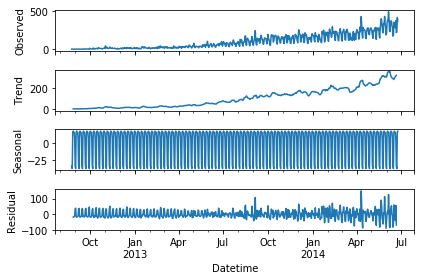

In [41]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()

#When the trend increases or decreases linearly, additive equation is used whereas when the trend increases or decreases
#exponentially, multiplicative equation is used.

result=sm.tsa.stattools.adfuller(Train.Count)
plt.show()

An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

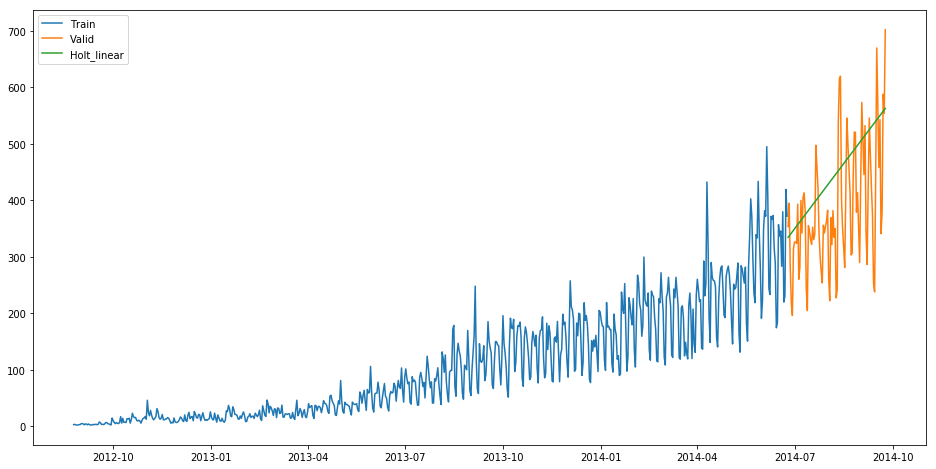

In [42]:
y_hat_avg = valid.copy()

fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

We can see an inclined line here as the model has taken into consideration the trend of the time series.

Let’s calculate the rmse of the model.

In [43]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear))
print(rms)

113.52677834630248


Now we will be predicting the passenger count for the test dataset using various models.

### 3. HOLT'S LINEAR TREND MODEL ON DAILY TIME SERIES:
Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.
Now let’s load the submission file.

In [44]:
submission=pd.read_csv('Sample_Submission_QChS6c3.csv')

We only need ID and corresponding Count for the final submission.

Let’s make prediction for the test dataset.

In [45]:
predict=fit1.forecast(len(test))   #using fit1(holt's linear trend model) dataframe for forecasting values of test file.

Let’s save these predictions in test file in a new column.

In [46]:
test['prediction']=predict

Remember this is the daily predictions. We have to convert these predictions to hourly basis. 
* To do so we will first calculate the ratio of passenger count for each hour of every day. 
* Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. 
* Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [47]:
# Calculating the hourly ratio of count (ratio of passenger count for each hour given in table for each day.)
train_original['ratio']=train_original['Count']/train_original['Count'].sum()
train_original.head(5)

,ID,Datetime,Count,Year,Month,Day,Hour,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,7.870093e-07


In [48]:
# Grouping the hourly ratio  (grouping hourly ratio of passenger count by suming the ratios of each hour,will get 24 ratios now.)
temp=train_original.groupby(['Hour'])['ratio'].sum()
temp

Hour
0     0.044287
1     0.035343
2     0.029911
3     0.024714
4     0.020802
5     0.018621
6     0.020023
7     0.023221
8     0.026741
9     0.034555
10    0.049047
11    0.054375
12    0.054951
13    0.048600
14    0.051965
15    0.051309
16    0.049999
17    0.051164
18    0.052423
19    0.055627
20    0.053455
21    0.049895
22    0.050076
23    0.048892
Name: ratio, dtype: float64

In [49]:
# Groupby to csv format
pd.DataFrame(temp, columns=['ratio']).to_csv('GROUPby.csv') #given only one column here as the 'Hour' column is already in temp.
temp2=pd.read_csv("GROUPby.csv")

In [53]:
#showing some rows of 'test' dataframe
test.head(5)

,ID,Year,Month,Day,Hour,prediction
Datetime,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,334.650767
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,337.159011
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,339.667256
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,342.175500
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,344.683745


In [55]:
#showing some rows of 'test_original' dataframe
test_original.head(5)

,ID,Datetime,Year,Month,Day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


test_original doesn't have prediction column whereas 'test' have prediction column. So merging test and test_original.

In [71]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('Day','Month', 'Year'), how='left')
merge.head()


,ID_x,Year,Month,Day,Hour_x,prediction,ID_y,Datetime,Hour_y
0,18299.5,2014,9,26,11.5,334.650767,18288,2014-09-26 00:00:00,0
1,18299.5,2014,9,26,11.5,334.650767,18289,2014-09-26 01:00:00,1
2,18299.5,2014,9,26,11.5,334.650767,18290,2014-09-26 02:00:00,2
3,18299.5,2014,9,26,11.5,334.650767,18291,2014-09-26 03:00:00,3
4,18299.5,2014,9,26,11.5,334.650767,18292,2014-09-26 04:00:00,4


In [72]:
#Now removing unnecessary columns from the merged table.
merge['Hour']=merge['Hour_y']
merge=merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1)

#  Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']


Let’s drop all other features from the submission file and keep ID and Count only.



In [74]:
submission=prediction.drop(['ID_x', 'Day', 'ID_y','prediction','Hour', 'ratio'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

Now let’s look at how well the Holt winters model predict the passenger counts for test dataset.

### 4. HOLT WINTER'S MODEL ON DAILY TIME SERIES:
- Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

- The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

- One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

Let’s first fit the model on training dataset and validate it using the validation dataset.

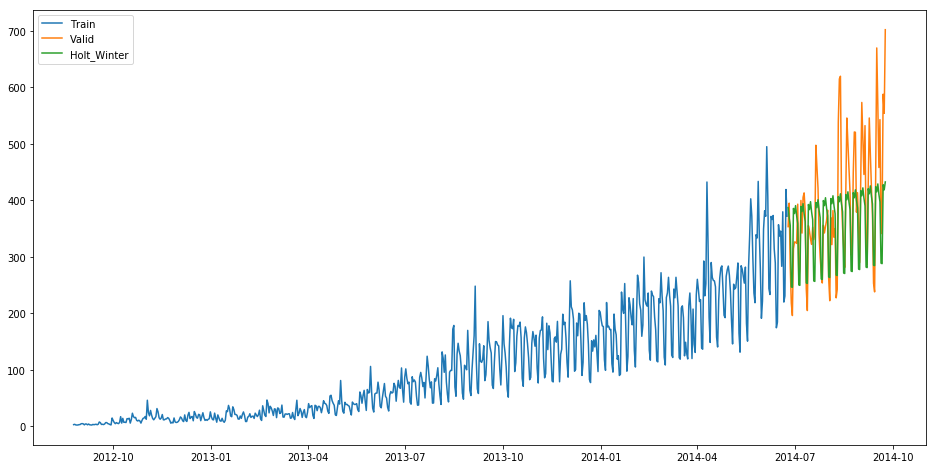

In [75]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [76]:
#Root mean square value for holt winter method:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))
print(rms)

80.7835257223916


We can see that the rmse value has reduced a lot from this method. Let’s forecast the Counts for the entire length of the Test dataset.

In [79]:
predict=fit1.forecast(len(test))   #gives predicted count of passenger in form of arrays. 

Now we will convert these daily passenger count into hourly passenger count using the same approach which we followed above.

In [80]:
test['prediction']=predict

In [84]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('Day','Month', 'Year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

Let’s drop all features other than ID and Count.

In [87]:
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['Day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv')


Till now we have made different models for trend and seasonality. Can’t we make a model which will consider both the trend and seasonality of the time series?

Yes we can. We will look at the ARIMA model for time series forecasting.

### 5. INTRODUCTION TO ARIMA MODEL:
ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

Here,
- p is the order of the autoregressive model(number of time lags)
- d is the degree of differencing(number of times the data have had past values subtracted)
- q is the order of moving average model. We will discuss more about these parameters in next section.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

**What is a stationary time series?**

There are three basic criterion for a series to be classified as stationary series :

- The mean of the time series should not be a function of time. It should be constant.
- The variance of the time series should not be a function of time.
- THe covariance of the ith term and the (i+m)th term should not be a function of time.

**Why do we have to make the time series stationary?**

We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data.

### 6. PARAMETER TUNING FOR ARIMA MODEL:

First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.

**Stationarity Check:**
- We use Dickey Fuller test to check the stationarity of the series.
- The intuition behind this test is that it determines how strongly a time series is defined by a trend.
- The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

In [92]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = pd.rolling_std(timeseries, window=24)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [93]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

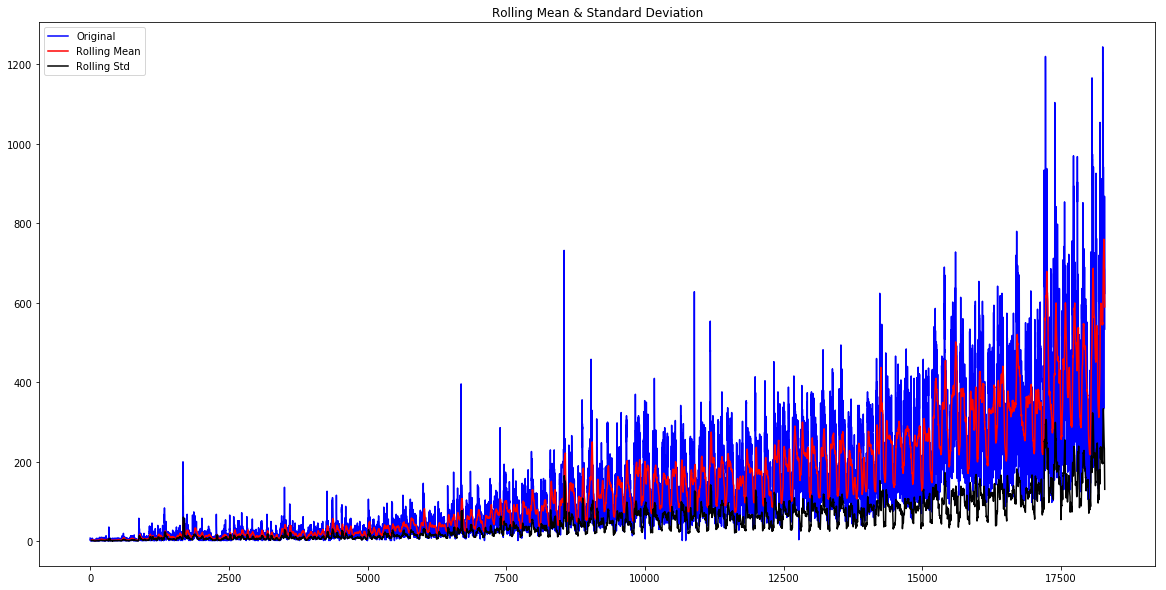

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [94]:
test_stationarity(train_original['Count']) #CALLING THE FUNCTION

The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

#### **Removing Trend**
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

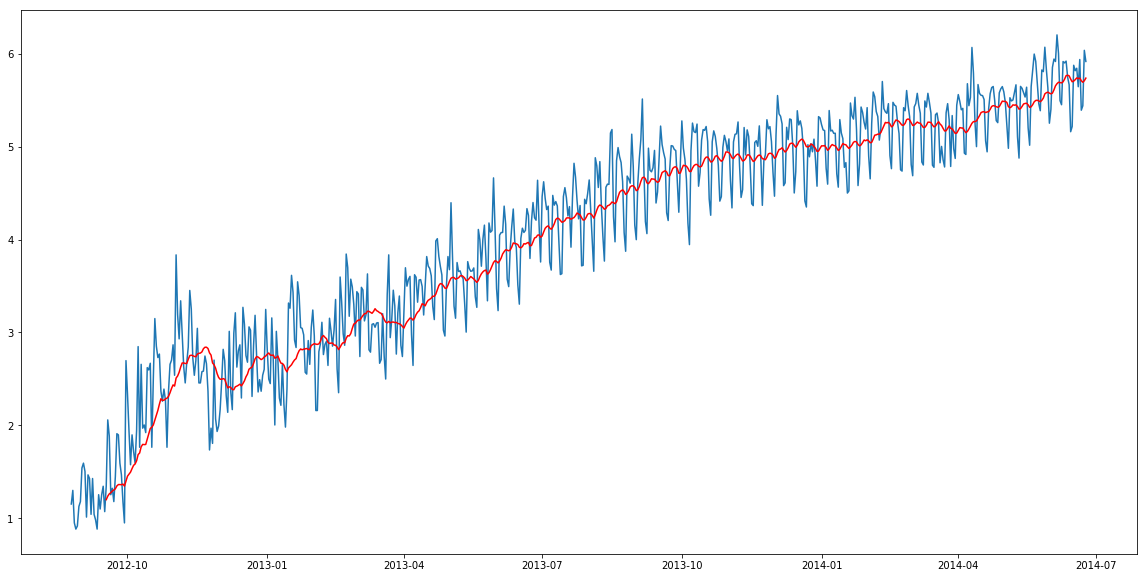

In [96]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

moving_avg = pd.rolling_mean(Train_log, 24)
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [97]:
train_log_moving_avg_diff = Train_log - moving_avg

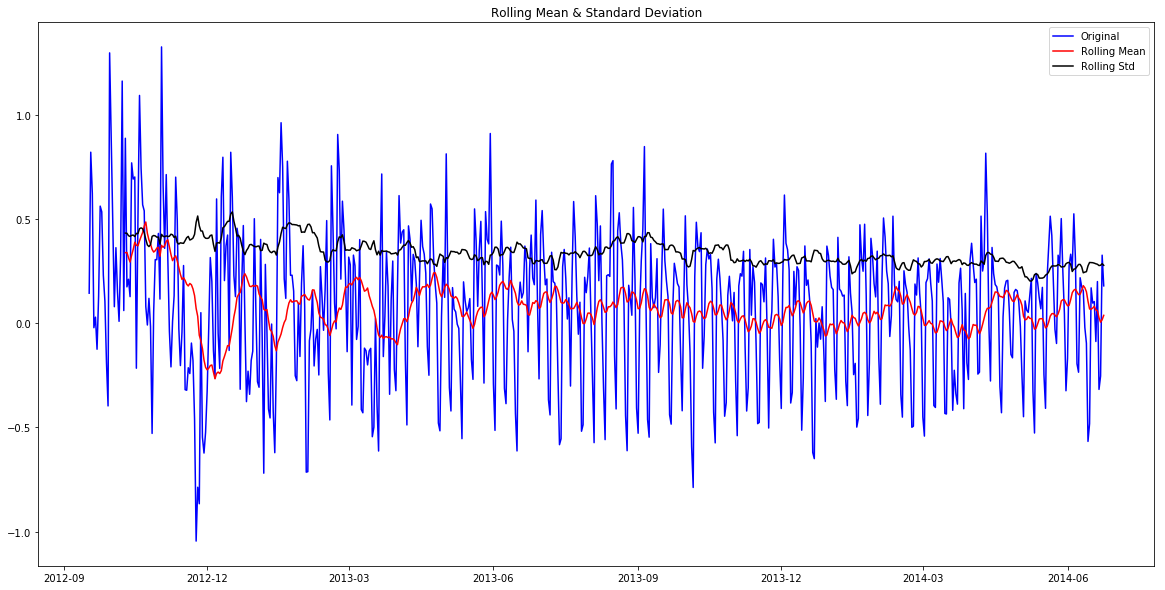

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [98]:
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.

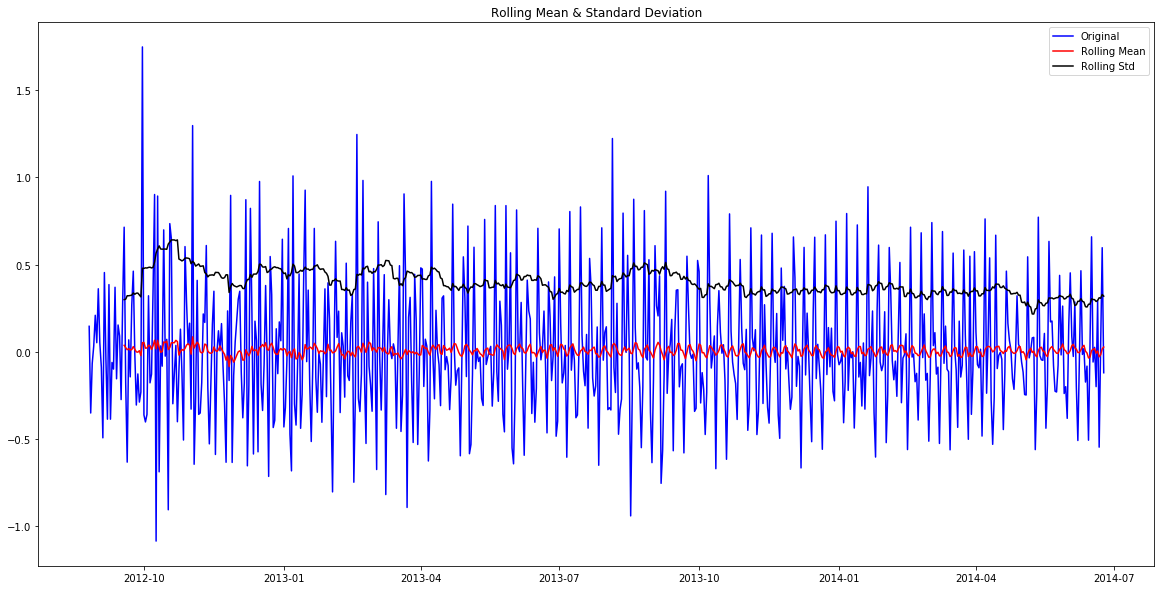

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [99]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

Removing Seasonality: 
By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
Seasonality is always of a fixed and known period.
We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.


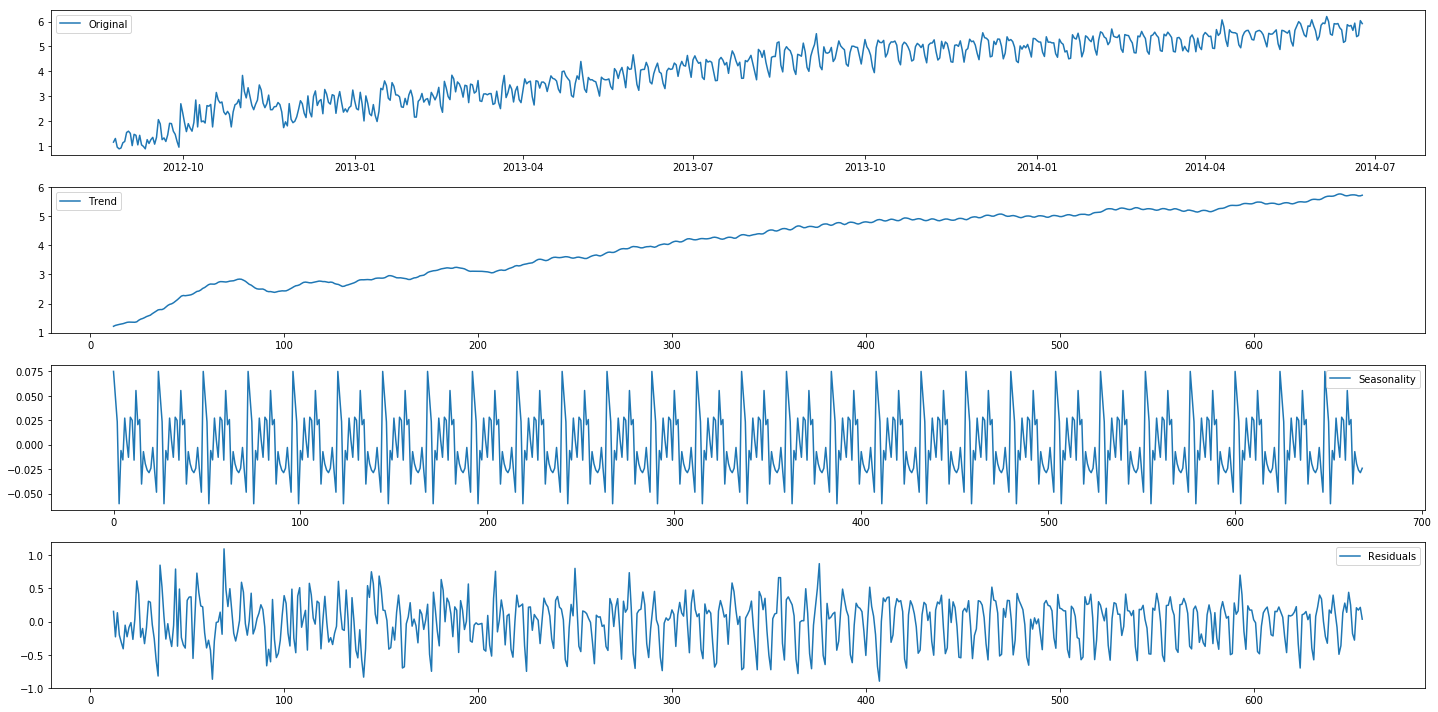

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.

Let’s check stationarity of residuals.

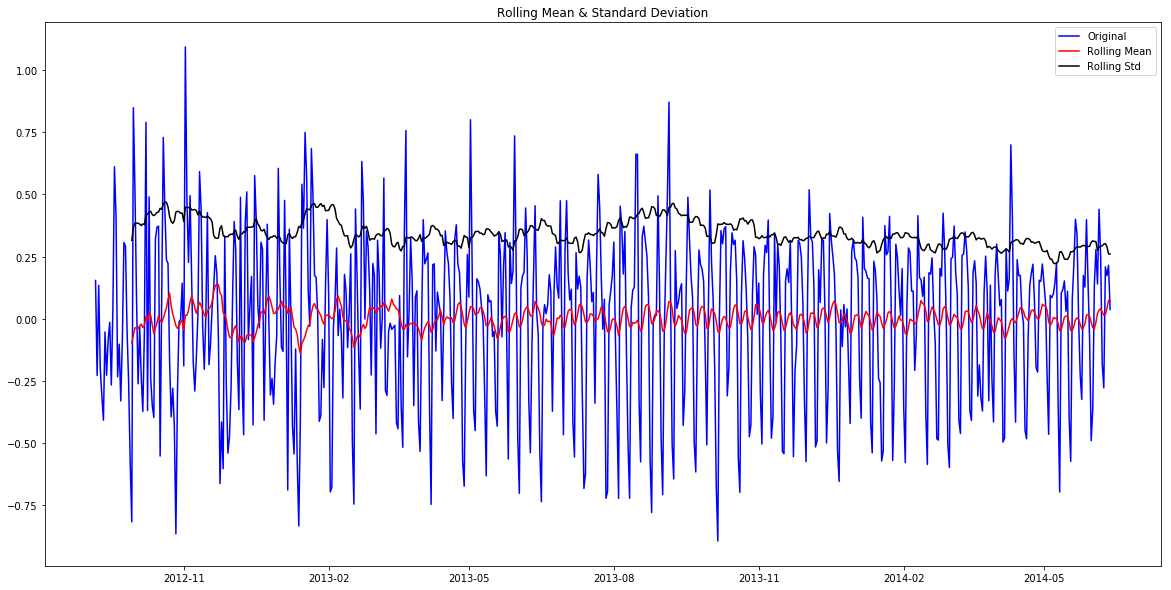

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [101]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

It can be interpreted from the results that the residuals are stationary.

Now we will forecast the time series using different models.

**Forecasting the time series using ARIMA**

First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

- ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

- PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [102]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

#### ACF and PACF plot

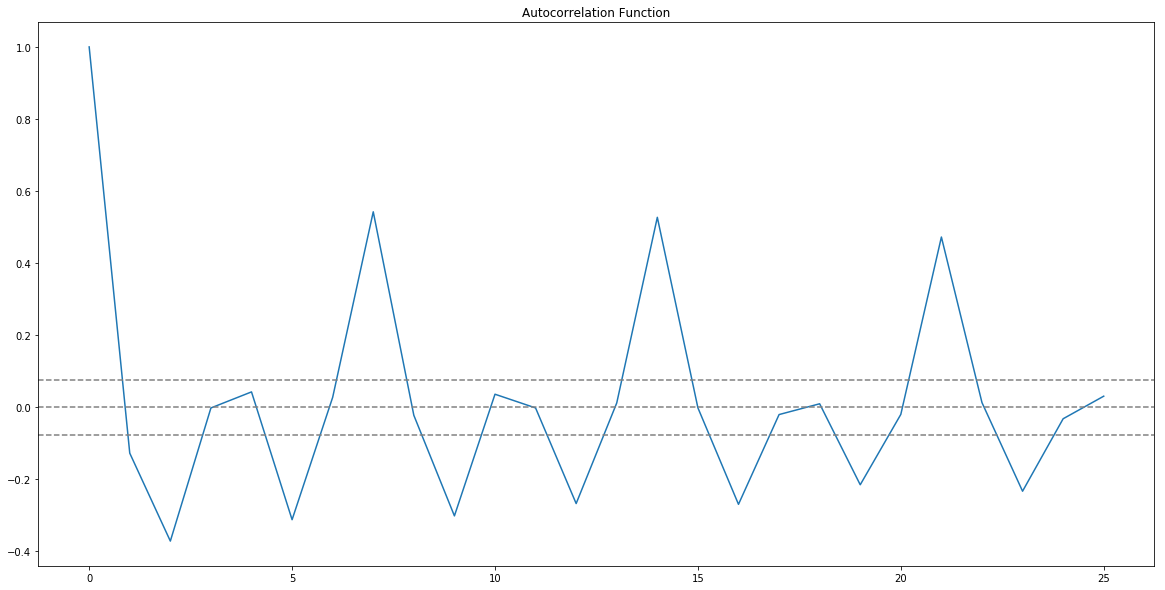

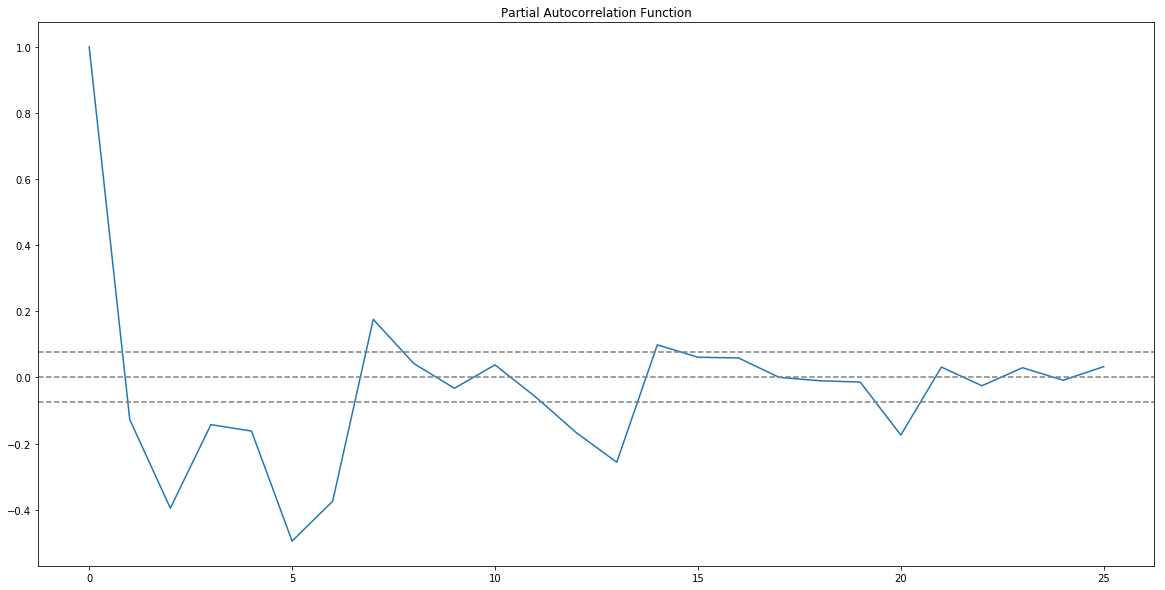

In [103]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()


- p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
- q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

#### AR model
The autoregressive model specifies that the output variable depends linearly on its own previous values.

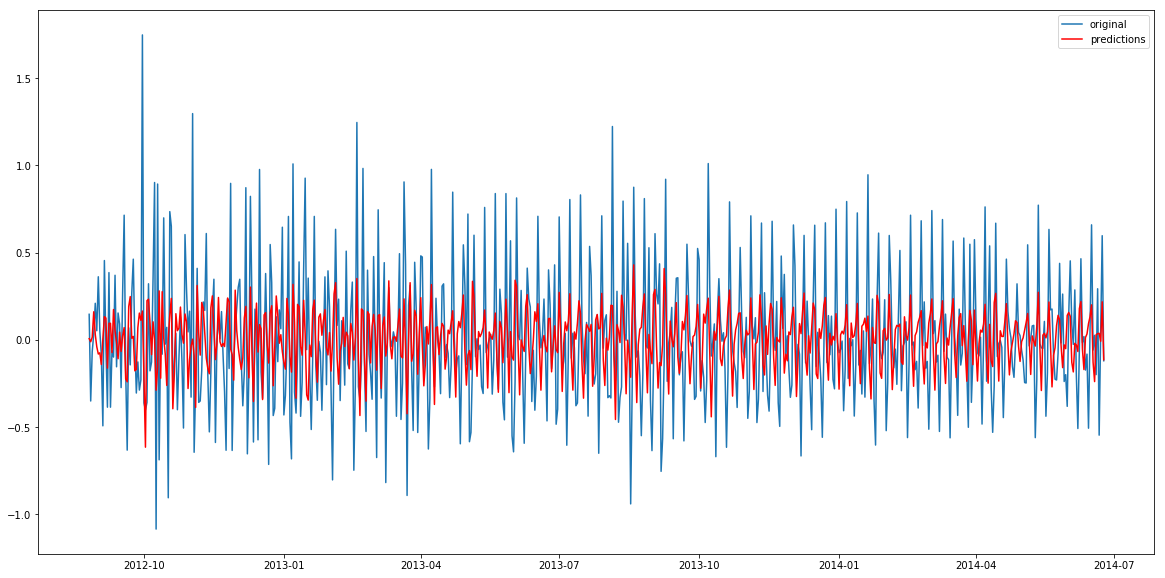

In [104]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')
plt.legend(loc='best')
plt.show()

Lets plot the validation curve for AR model.

We have to change the scale of the model to the original scale.

First step would be to store the predicted results as a separate series and observe it.

In [108]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict=AR_predict.cumsum().shift().fillna(0)
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

ValueError: shapes (93,) and (92,) not aligned: 93 (dim 0) != 92 (dim 0)

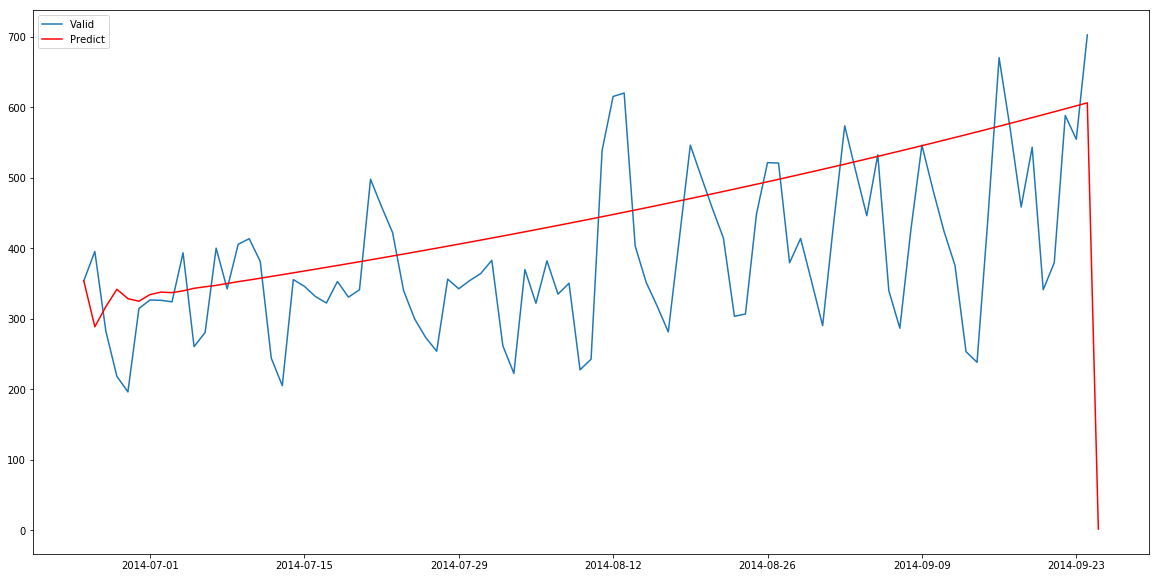

In [109]:
plt.plot(valid['Count'], label = "Valid")
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

Here the red line shows the prediction for the validation set. Let’s build the MA model now.

#### MA model
The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

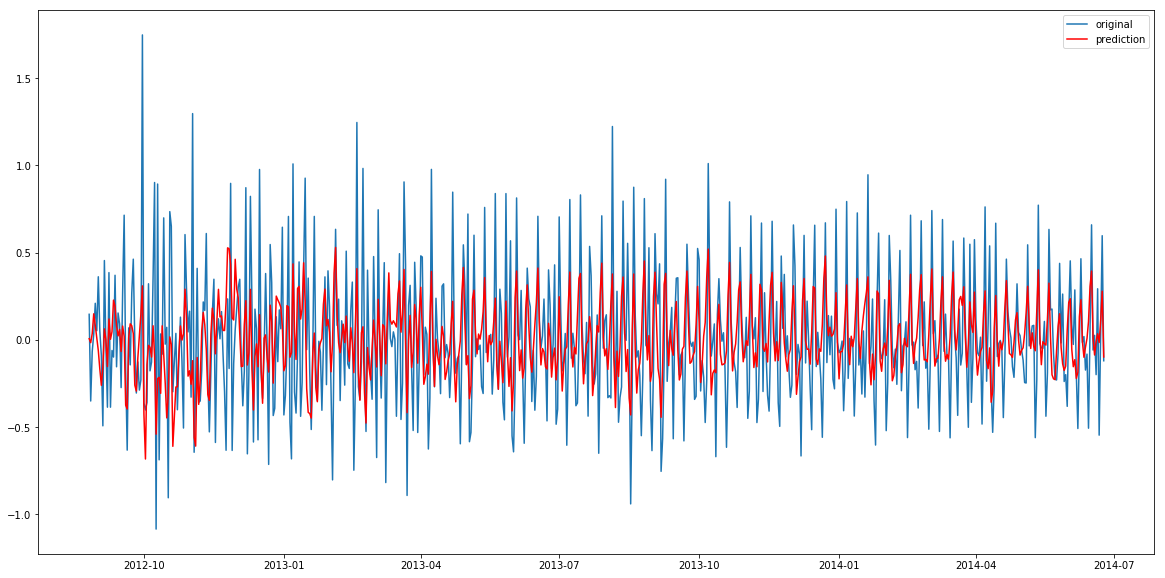

In [110]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')
plt.legend(loc='best')
plt.show()


In [111]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

ValueError: shapes (93,) and (92,) not aligned: 93 (dim 0) != 92 (dim 0)

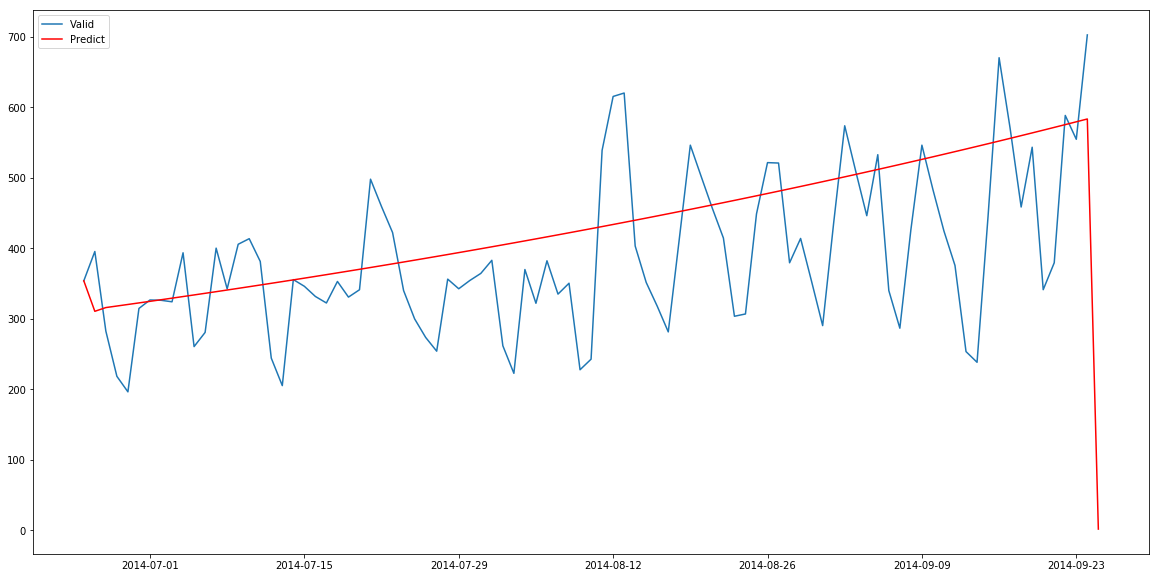

In [112]:
plt.plot(valid['Count'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

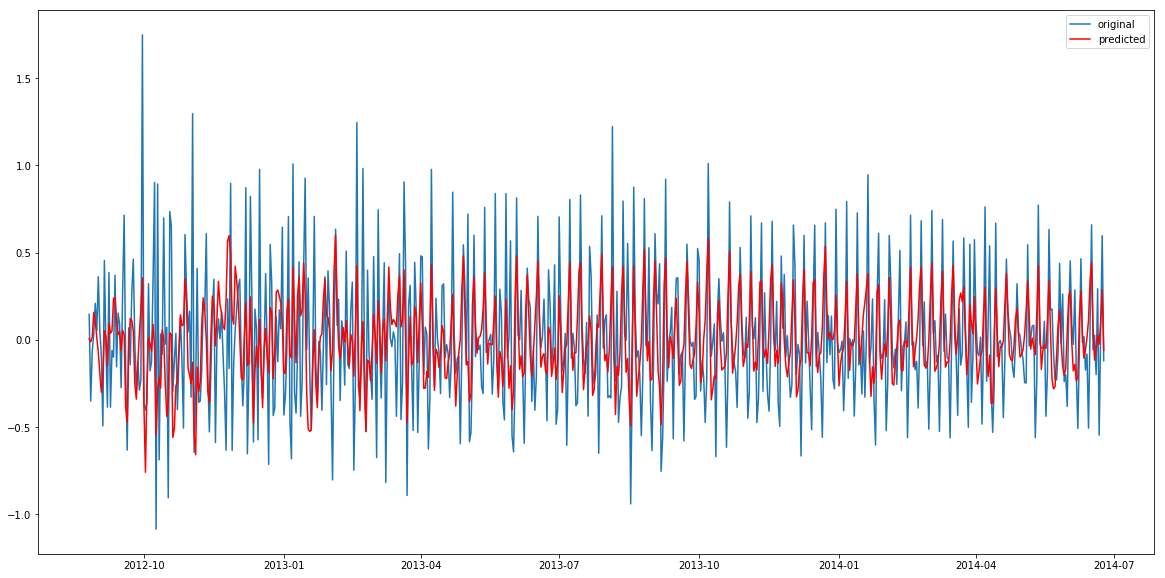

In [113]:
#Combined model

model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

Let’s define a function which can be used to change the scale of the model to the original scale.

In [115]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [116]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

Let’s predict the values for validation set.

In [118]:

ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

ValueError: shapes (93,) and (92,) not aligned: 93 (dim 0) != 92 (dim 0)

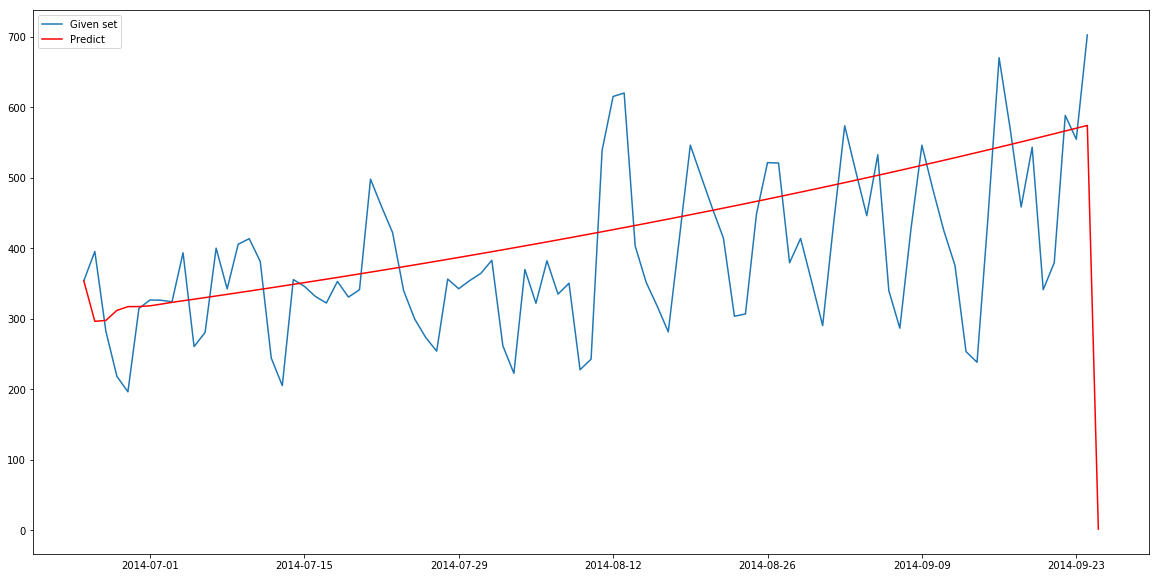

In [119]:
check_prediction_diff(ARIMA_predict_diff, valid)

### 7. SARIMAX MODEL ON DAILY TIME SERIES:
SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

In [120]:
import statsmodels.api as sm

C:\Users\Vibhuti Mathur\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


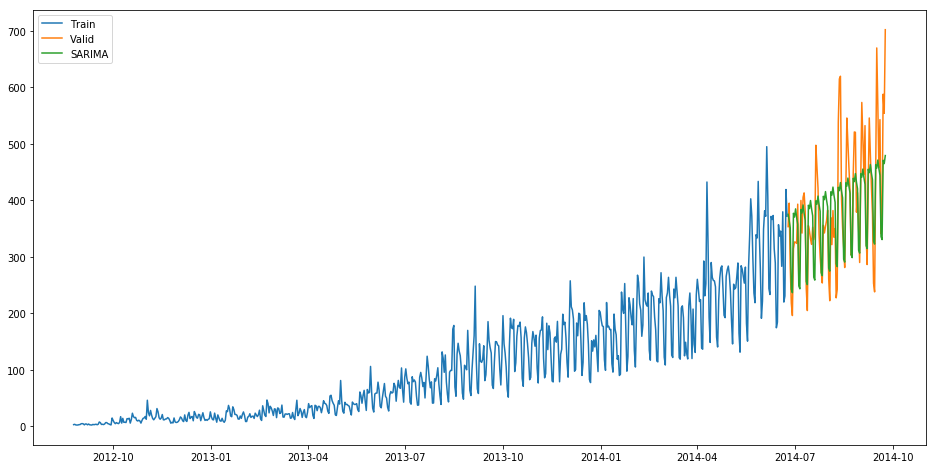

In [121]:
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

- Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

- Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

Let’s check the rmse value for the validation part.

In [122]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
print(rms)

69.26943622723743


Now we will forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

In [124]:
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)

C:\Users\Vibhuti Mathur\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Note that these are the daily predictions and we need hourly predictions. So, we will distribute this daily prediction into hourly counts. To do so, we will take the ratio of hourly distribution of passenger count from train data and then we will distribute the predictions in the same ratio.

In [125]:
test['prediction']=predict

In [128]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('Day','Month', 'Year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [130]:
#Let’s drop all variables other than ID and Count

prediction['ID']=prediction['ID_y']
submission=prediction.drop(['Day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')